$Author:$ Arne Fabritius
<br>
$Institution:$ Max Planck Institute for Neurobiology
<br>
$Group:$ Tools for Bioimaging, Oliver Griesbeck
<br>
$Revised:$ 2020-02-06
<br>
$Reference:$ 
<br>
Erdogan, M., Fabritius, A., Basquin, J. and Griesbeck, O.
<br>
Targeted In Situ Protein Diversification and Intra-Organelle Validation in Mammalian Cells,
<br>
Cell Chemical Biology, 2020
<br>
$Purpose:$ 
Analysis of next generation sequencing data for a CRISPR/Cas9 diversified gene library of the fluorescent protein mRuby3, for the purpose of engineering the highly pH resistant fluorescent protein mCRISPRed.

### Data

Raw data was deposited into the Squence Read Archive (SRA) of the U.S. National Library of Medicine 
<br>
from the National Center for Biotechnoly Information (NCBI) 
<br>
Accession numbers:
<br>
SAMN14055904 - NGS1 
<br>
SAMN14055905 - NGS2
<br>
SAMN14055906 - NGS3
<br>
SAMN14055907 - NGS4

### Libraries to import

In [104]:
### basic 
import re
import regex
import numpy as np

### plotting
import matplotlib.pyplot as plt
import seaborn as sns

### handling of sequence data
from Bio.Seq import Seq                         
from Bio import SeqIO
from Bio.Alphabet import IUPAC     

%matplotlib inline

### Code

In [14]:
%%time
# Data pre-processing: 
# paired-end reads from Illumina MiSeq were aligned and merged using NGmerge (Gaspar et al. 2018)
#
# This script filters the resulting fastQ file for phred quality scores > 30 for all bases 
# and creates a new fasta file which is used in all further analysis.

### input section 

### input-file location and filename 

folder=""
filename = "L5_merged.fastq"


### output-file location and filename
infile = folder+filename
outfile= open(folder+re.split(".fastq",filename)[0]+"_Q30.fasta","w")

###############################################################################################################################

### initialize counters
count=0
count_Q30=0

### loop through input file and filter for Q>30 
with open(infile, "rU") as handle_file:
    for record in SeqIO.parse(handle_file, "fastq"):
        count+=1
        if min(record.letter_annotations["phred_quality"]) >= 30:
            outfile.write(">" + record.id + "\n")
            outfile.write(str(record.seq) + "\n")
            count_Q30+=1


outfile.close() 


### output 
print ("Total of %d sequences processed" % (count))
print ("Total of %d sequences with >Q30" % (count_Q30))
print ("Total of %3.1f %% sequences with >Q30" % (count_Q30/float(count)*100))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 'U' mode is deprecated


Total of 2498184 sequences processed
Total of 1579664 sequences with >Q30
Total of 63.2 % sequences with >Q30
Wall time: 1min 10s


In [2]:
%%time
# This script processes a fasta file, which contains aligned paired-end-reads filtered for a quality score of Q>30 for all bases.  
# The reads resulted from illumina  MiSeq next generation sequencing of a diversified library of the fluorescent protein mRuby3


### input file section

### file locattion and filename
folder="C:\\Users\\afabritius\\Documents\\Python Scripts\\20190429_Test_folder\\20190805_NGSalignment_NGmerge\\"
filename="L5_merged_Q30.fasta"
infile = folder+filename

### sequences which identify region of interest 
ID_Pattern = re.compile("GCCAGGAACGAGTTC")
gene_primer = re.compile("TCAGAGGGGTAAACTTTCCC")
cDNA = re.compile("TCGTAACAACTTACAGGTCA")


####################################################################################################################

### initalize counters
all_count=0            ### all processed sequences
count=0                ### valid sequence count
count_no_ID=0          ### squences that miss either of the 3 identifying regions
UMI_off_count =0       ### UMI sequences which are not of length 20 bp
count_len_cor=0        ### sequences with expected length when correctly edited with HDR

### initialize sequence dictionaries
UMI_dic = {}           ### unique molecular identifiers (UMI) 
DNA_dic ={}            ### unique DNA seuqences 
length_dict ={}        ### length of 


### this loops through all sequences in the provided fasta file 

with open(infile, "rU") as handle_file:
    for record in SeqIO.parse(handle_file, "fasta"):
        DNA = str(record.seq)
        all_count+=1
        
        ### checks for presence of identifying region in current DNA sequence
        if ID_Pattern.search(DNA) and gene_primer.search(DNA) and cDNA.search(DNA):
            
            ### extracts Unique molecular identifiers (UMI)
            DNA_1 = re.split(gene_primer,DNA)[1] 
            DNA_2 = re.split(cDNA,DNA_1)[0]
            UMI = re.split(cDNA,re.split(ID_Pattern,DNA)[0])[-1]
                            
            ### checks if UMI has predetermined length of 20 bp
            if len(UMI)==20:
                    
                ### UMI is added to UMI dictionary and counted    
                if UMI not in UMI_dic:
                    UMI_dic[UMI] = 1
                    count+=1
                    
                    ### length of current DNA sequence is added to length dictionary and counted
                    if len(DNA_2) not in length_dict:
                        length_dict[len(DNA_2)] = 1
                    elif len(DNA_2) in length_dict:
                        length_dict[len(DNA_2)]+= 1
                    
                    ### check for expected length of DNA when repaired correctly with HDR
                    if len(DNA_2) == 139:
                        count_len_cor+=1
                        
                        ### Adds unique DNA sequences to DNA dictionary and counts
                        if DNA_2[0:-1] not in DNA_dic:
                            DNA_dic[DNA_2[0:-1]] =1
                        elif DNA_2[0:-1] in DNA_dic:
                            DNA_dic[DNA_2[0:-1]]+=1
                            
                elif UMI in UMI_dic:
                    UMI_dic[UMI] += 1
            
            ### counting sequences with incorrect UMI length                    
            else:
                UMI_off_count+=1
        ### counting sequences missing identifying sequence parts    
        else:
            count_no_ID+=1
            
### Output           
            
print(" %d sequences processed" % all_count)
print(" %d sequences have unique valid UMI" % count)
print(" %d sequences miss identifier" % count_no_ID)
print(" %d sequences have invalid UMI" % UMI_off_count)
print(" %d sequences have correct length" % count_len_cor)
print(" %d unique DNA sequences with correct length" % len(DNA_dic))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: 'U' mode is deprecated


 1579664 sequences processed
 1422115 sequences have unique valid UMI
 123683 sequences miss identifier
 29519 sequences have invalid UMI
 262300 sequences have correct length
 78977 unique DNA sequences with correct length
Wall time: 22 s


In [3]:
### library for DNA/protein sequences in full sequenced region

long_oligo_lib={}       ### library for unique DNA sequences
long_peptide_lib = {}   ### library for unique protein sequences

### creates dictionary for unique DNA seuqences  
for dna in DNA_dic.keys():
    oligo = dna[0:139]
    if oligo not in long_oligo_lib:
        long_oligo_lib[oligo] = DNA_dic[dna]
    elif oligo in long_oligo_lib:
        long_oligo_lib[oligo] += DNA_dic[dna]

### loops through unique DNA sequences, translates DNA and adds unique protein sequences to dictionary     
for oligo in long_oligo_lib:
    peptide = str(Seq(oligo, IUPAC.unambiguous_dna).translate())
    
    if peptide not in long_peptide_lib:
        long_peptide_lib[peptide] = long_oligo_lib[oligo]
    elif peptide in long_peptide_lib:
        long_peptide_lib[peptide] += long_oligo_lib[oligo]
        
### output

print(" %d unique variants on DNA level" % len(long_oligo_lib))
print(" %d unique variants on protein level" % len(long_peptide_lib))

 78977 unique variants on DNA level
 72837 unique variants on protein level


In [4]:
### library for DNA/protein sequences in modified region P146 N147 E149 T162 I164
oligo_lib={}       ### library for unique DNA sequences
peptide_lib = {}   ### library for unique protein sequences


### loops through unique DNA sequences with correct length, pics modified position and extracts DNA sequence of position
for dna in DNA_dic.keys():
    oligo = dna[42:48]+dna[51:54]+dna[90:93]+dna[96:99]
    if oligo not in oligo_lib:
        oligo_lib[oligo] = DNA_dic[dna]
    elif oligo in oligo_lib:
        oligo_lib[oligo] += DNA_dic[dna]

### loops through unique DNA sequences, translates DNA and adds unique protein sequences to dictionary        
for oligo in oligo_lib:
    peptide = str(Seq(oligo, IUPAC.unambiguous_dna).translate())
    
    if peptide not in peptide_lib:
        peptide_lib[peptide] = oligo_lib[oligo]
    elif peptide in peptide_lib:
        peptide_lib[peptide] += oligo_lib[oligo]        

### output

print(" %d unique variants in modified region on DNA level" % len(oligo_lib))
print(" %d unique variants in modified region on protein level" % len(peptide_lib))   

 67467 unique variants in modified region on DNA level
 64204 unique variants in modified region on protein level


### Figure 2
    

    

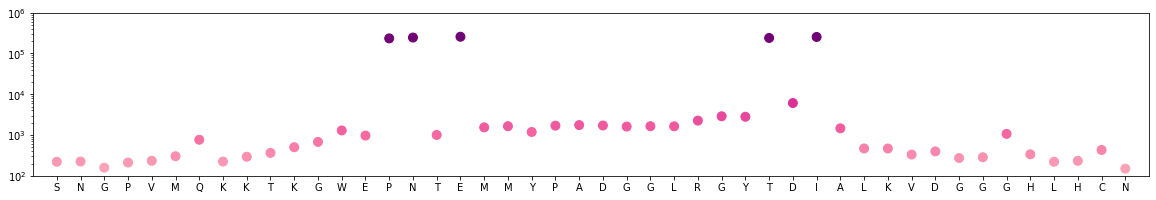

In [5]:
### Plot for Figure 2C top


### generate x-label from wt DNA sequence
wt_seq = "TCCAATGGTCCCGTGATGCAGAAGAAGACCAAGGGTTGGGAGCCTAATACAGAGATGATGTATCCAGCAGATGGTGGTCTGAGGGGATACACTGATATTGCACTGAAAGTTGATGGTGGTGGCCATCTGCATTGCAAC"

label_list = []
for i in str(Seq(wt_seq, IUPAC.unambiguous_dna).translate()):
    label_list.append(i)

counter_array = np.zeros(46)   ### initialize counter 

### loop through protein library and counts occurcane of none-wt amino acids in each position
for peptide in long_peptide_lib.keys():
    for i in range(0,46):
        if peptide[i] != label_list[i]:
            counter_array[i] += long_peptide_lib[peptide]

### figure parameters           
plt.figure(figsize=(20,3))
plt.yscale('log')
plt.ylim(100,1000000)
plt.xlim(-1,46)

plt.scatter(range(0,46),counter_array,c=np.log10(counter_array), vmin=0, vmax=6, s=80, cmap="RdPu")

## labels
plt.xticks(range(0,46), label_list);

### saving vectorized figure
plt.savefig("Figure_2C_top.svg")   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


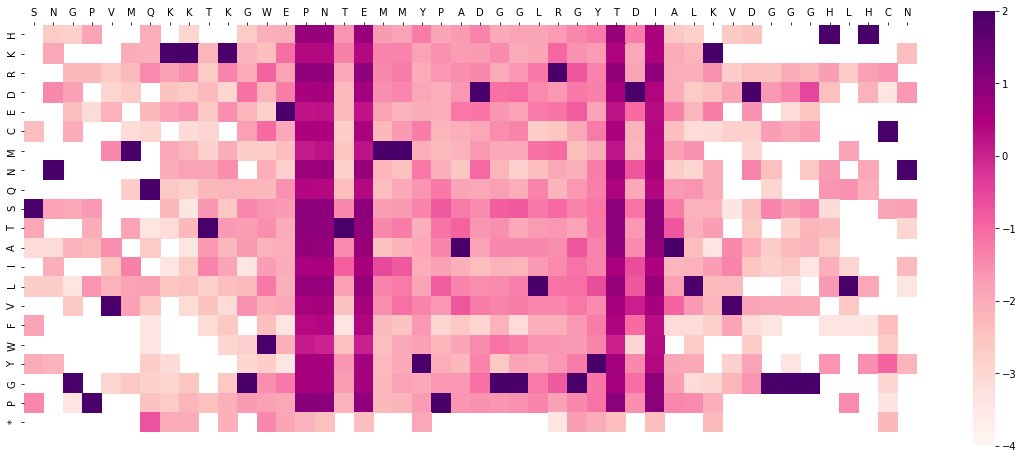

In [6]:
### Plot for Figure 2C bottom

### list of amino acids
amino_acids = np.array(("H","K","R","D","E","C","M","N","Q","S","T","A","I","L","V","F","W","Y","G","P","*"))
### initialize counting table 
long_counting_table = np.zeros((46,21))

### loop through protein library and count amino acids in each position 
for peptide in long_peptide_lib.keys():
    for i in range(0,46):
        for n in range(0,21):
            if peptide[i] == amino_acids[n]:
                long_counting_table[i,n] += long_peptide_lib[peptide]


                
### figure parameters
plt.figure(figsize=(20,8))

### labels
ax = plt.axes()
ax.xaxis.set_ticks_position('top');



### plot heatmap 
sns.heatmap(np.log10(long_counting_table/float(sum(long_peptide_lib.values()))*100).transpose(),
            vmin=-4,vmax=2, cmap="RdPu", xticklabels=label_list, yticklabels=amino_acids,
            cbar_kws={"orientation": "vertical"}, square =True );

plt.yticks(rotation=0);


### save vectorized figure
plt.savefig("Figure_2C_bottom.svg")

### Figure 3

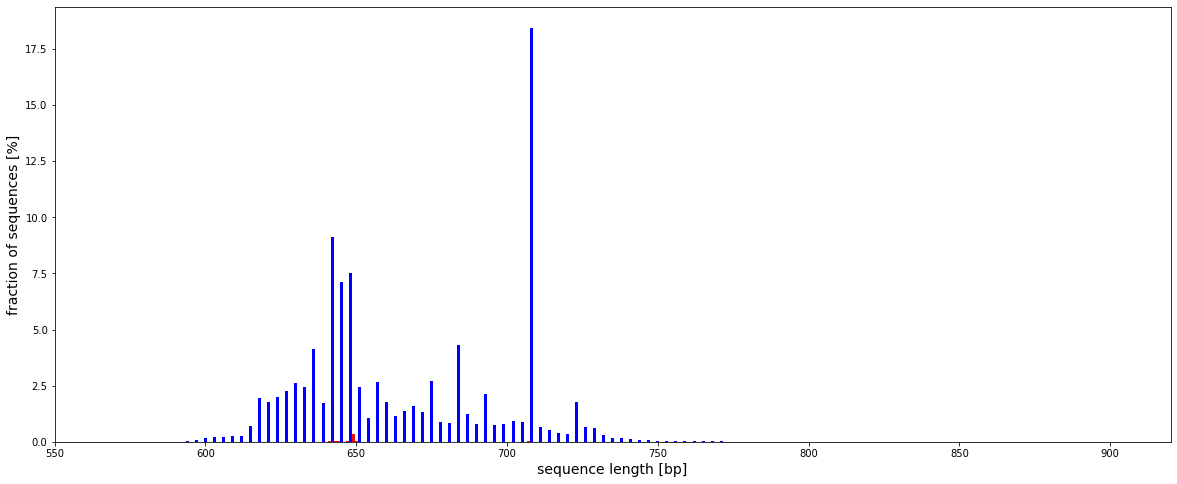

In [113]:
### Plot for Figure 3A left side

### define figure parameters
plt.figure(figsize=(20,8))
plt.xlim(550,920)
plt.ylabel('fraction of sequences [%]', fontsize=14)
plt.xlabel('sequence length [bp]', fontsize=14)

### differenciate between in frame and out of frame, plot blue and red respectively
for key in length_dict.keys():
    if (key-1) % 3 == 0:
        plt.bar(key+569,100*length_dict[key]/float(sum(length_dict.values())),width=1,linewidth=0.2,color="blue");
    else:
        plt.bar(key+569,100*length_dict[key]/float(sum(length_dict.values())),width=1,linewidth=0.2,color="red");
        
### saving vectorized figure
plt.savefig("Figure_3A_1.svg")   

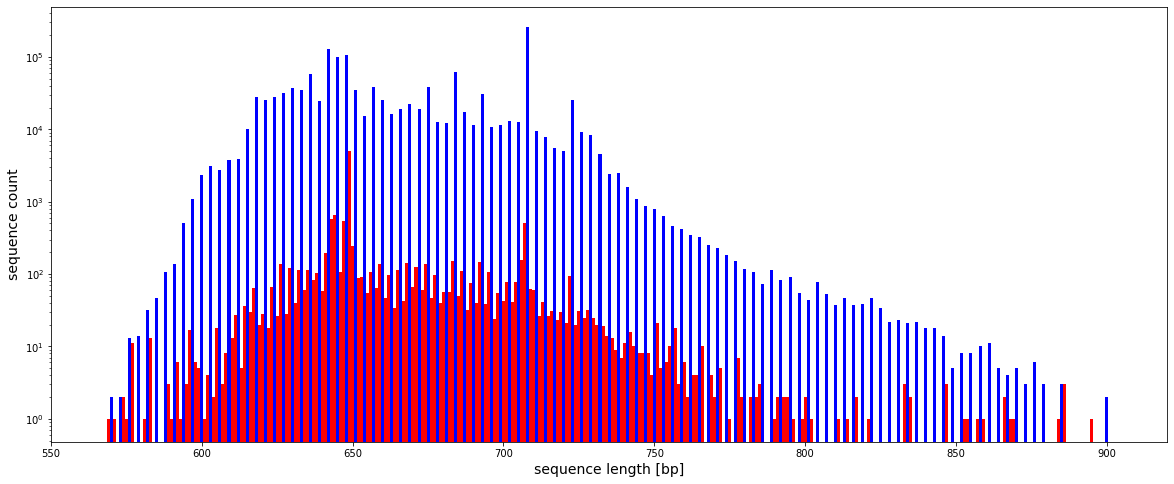

In [114]:
### Plot for Figure 3A right side

### define figure parameters
plt.figure(figsize=(20,8))
plt.yscale('log')
plt.xlim(550,920)
plt.ylabel('sequence count', fontsize=14)
plt.xlabel('sequence length [bp]', fontsize=14)

### differenciate between in frame and out of frame, plot blue and red respectively
for key in length_dict.keys():
    if (key-1) % 3 == 0:
        plt.bar(key+569,length_dict[key],width=1,linewidth=0.2,color="blue");
    else:
        plt.bar(key+569,length_dict[key],width=1,linewidth=0.2,color="red");
    
### saving vectorized figure    
plt.savefig("Figure_3A_2.svg")     


In [9]:
### Figure 3A inset 

### count in-frame and out of frame variants

frame_counter = np.zeros(2)  ### initialize 

### loops through all lengths and checks if in frame or not and counts instances 
for length in length_dict.keys():
    if (length-1) % 3 == 0:
        frame_counter[0] += length_dict[length]
    else:
        frame_counter[1] += length_dict[length]

### calculate percent 
ratios = frame_counter/float(sum(frame_counter))*100     

### output 
print("in frame: %2.1f %% out of frame: %2.1f %%" % (ratios[0],ratios[1]))

in frame: 99.1 % out of frame: 0.9 %


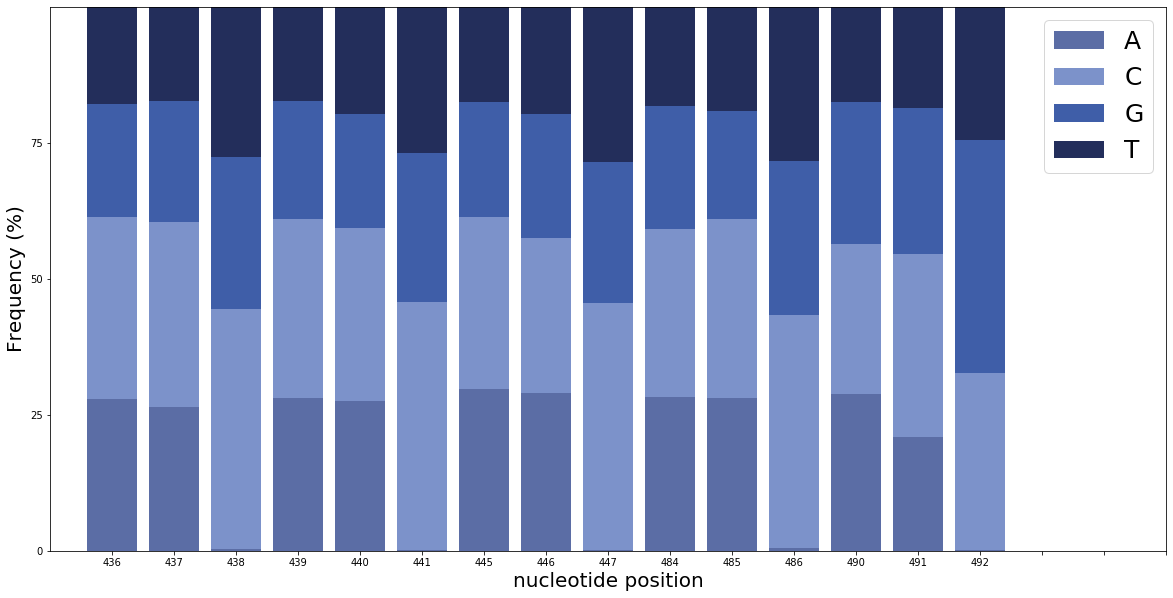

In [15]:
### Plot for Figure 3B

### calculate frequency for each base within unique DNA variants 

base_counter = np.zeros((4,15))      ### initialize counting table
bases = ["A","C", "G","T"]           ### look-up list for bases

### loop through DNA sequences in modified region
for oligo in oligo_lib.keys():
    for i in range(0,len(oligo)):
        for n in range(0,len(bases)):
            if oligo[i] == bases[n]:
                base_counter[n,i]+=1

### calculate observed base frequency in each position                
base_freq = base_counter/float(sum(base_counter[0:4,0]))*100  

### plot bars
plt.figure(figsize=(20,10))
p1 = plt.bar(np.arange(len(base_freq[0])),base_freq[0], color="#5B6DA5")
p2 = plt.bar(np.arange(len(base_freq[0])),base_freq[1], color ="#7C92CA", bottom=base_freq[0])
p3 = plt.bar(np.arange(len(base_freq[0])),base_freq[2], color ="#3F5EA8", bottom=base_freq[0]+base_freq[1])
p4 = plt.bar(np.arange(len(base_freq[0])),base_freq[3], color ="#232E5B", bottom=base_freq[0]+base_freq[1]+base_freq[2])

### figure parameters 
axes = plt.gca()
axes.set_ylim([0,100])
axes.set_xlim([-1,12])
plt.legend((p1,p2,p3,p4),("A","C","G","T"), loc = 0, fancybox=True, fontsize=25)

### labels 
plt.yticks(np.arange(0,100,25))
plt.xticks(np.arange(0,18,1),[436,437,438,439,440,441,445,446,447,484,485,486, 490,491,492])
plt.ylabel('Frequency (%)', fontsize=20)
plt.xlabel('nucleotide position', fontsize=20)

### saving vectorized figure
plt.savefig("Figure_3B.svg")   

### output
plt.show()

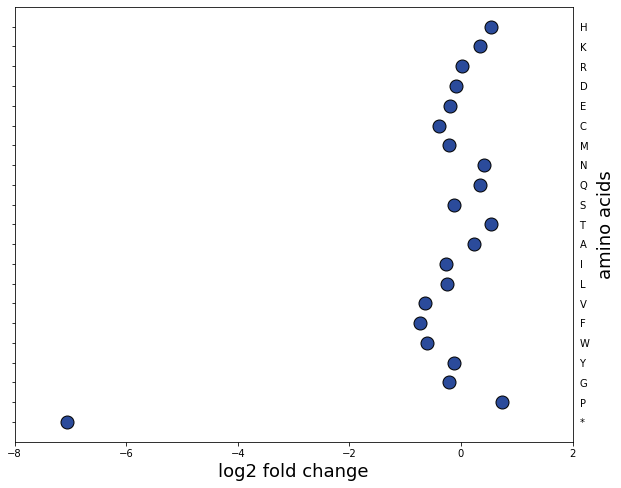

In [11]:
### Plot Figure 3C


### list of amino acids 
amino_acids = np.array(("H","K","R","D","E","C","M","N","Q","S","T","A","I","L","V","F","W","Y","G","P","*"))
### list of number of codons for each amino acid when NNB is used as codon
codn_freq_NNB = np.array((2,1,4,2,1,2,1,2,1,5,3,3,2,4,3, 2,1,2,3,3,1))


peptide_counter_lib = {}                  ### initialize amino acid library
unique_counting_table = np.zeros((5,21))  ### initialize counting table

### loop through DNA library in modified position, translate and add to amino acid library
for oligo in oligo_lib:
    peptide = str(Seq(oligo, IUPAC.unambiguous_dna).translate())
    
    if peptide not in peptide_counter_lib:
        peptide_counter_lib[peptide] = 1
    elif peptide in peptide_lib:
        peptide_counter_lib[peptide] +=1 

### count amino acids in modified region 

for peptide in peptide_counter_lib.keys():
    for i in range(0,5):
        for n in range(0,21):
            if peptide[i] == amino_acids[n]:
                unique_counting_table[i,n] += peptide_counter_lib[peptide]

### calculate observed and expected frequency for each amino acid                
unique_observed_freq = np.sum(unique_counting_table, axis=0)/np.sum(unique_counting_table)
expected_freq = codn_freq_NNB/float(sum(codn_freq_NNB))


### figure parameters
plt.figure(figsize=(10,8))
plt.xlim(-8,2)
plt.ylim(-1,21)


### labels 
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.yticks(range(0,21),amino_acids[::-1])
plt.ylabel('amino acids', labelpad=-600, fontsize=18)
plt.xlabel("log2 fold change", fontsize=18)
plt.plot((np.log2(unique_observed_freq)-np.log2(expected_freq))[::-1],range(0,21),
         marker = 'o', linestyle = '', markerfacecolor='#9D9D9C', markeredgecolor='k', markersize=13);


### save vectorized image 
plt.savefig("Figure_3C.svg")

### Figure 4

In [19]:
%%time
# For figure 4 all viable DNA sequences have to be collected, therefor data needs to be processed differntly.
# This script processes a fasta file, which contains aligned paired end reads filtered for a quality score of Q>30 for all bases.  
# The reads resulted from illumina  MiSeq next generation sequencing of a diversified library of the fluorescent protein mRuby3


### input file section

### file locattion and filename
folder="C:\\Users\\afabritius\\Documents\\Python Scripts\\20190429_Test_folder\\20190805_NGSalignment_NGmerge\\"
filename="L5_merged_Q30.fasta"
infile = folder+filename

### sequences which identify region of interest 
ID_Pattern = re.compile("GCCAGGAACGAGTTC")
gene_primer = re.compile("TCAGAGGGGTAAACTTTCCC")
cDNA = re.compile("TCGTAACAACTTACAGGTCA")


####################################################################################################################

### initalize counters
all_count=0            ### all processed sequences
count=0                ### valid sequence count
count_no_ID=0          ### squences that miss either of the 3 identifying regions
UMI_off_count =0       ### UMI sequences which are not of length 20 bp
count_len_cor=0        ### sequences with expected length when correctly edited with HDR

### initialize sequence dictionaries
UMI_dic = {}           ### unique molecular identifiers (UMI) 
DNA_dic_all ={}        ### unique DNA seuqences 



### this loops through all sequences in the provided fasta file 

with open(infile, "rU") as handle_file:
    for record in SeqIO.parse(handle_file, "fasta"):
        DNA = str(record.seq)
        all_count+=1
        
        ### checks for presence of identifying region in current DNA sequence
        if ID_Pattern.search(DNA) and gene_primer.search(DNA) and cDNA.search(DNA):
            
            ### extracts Unique molecular identifiers (UMI)
            DNA_1 = re.split(gene_primer,DNA)[1] 
            DNA_2 = re.split(cDNA,DNA_1)[0]
            UMI = re.split(cDNA,re.split(ID_Pattern,DNA)[0])[-1]
                            
            ### checks if UMI has predetermined length of 20 bp
            if len(UMI)==20:
                    
                ### UMI is added to UMI dictionary and counted    
                if UMI not in UMI_dic:
                    UMI_dic[UMI] = 1
                    count+=1
                                        

                        
                    ### Adds unique DNA sequences to DNA dictionary and counts
                    if DNA_2[0:-1] not in DNA_dic_all:
                        DNA_dic_all[DNA_2[0:-1]] =1
                    elif DNA_2[0:-1] in DNA_dic_all:
                        DNA_dic_all[DNA_2[0:-1]]+=1
                            
                elif UMI in UMI_dic:
                    UMI_dic[UMI] += 1
            
            ### counting sequences with incorrect UMI length                    
            else:
                UMI_off_count+=1
        ### counting sequences missing identifying sequence parts    
        else:
            count_no_ID+=1
            
### Output           
            
print(" %d sequences processed" % all_count)
print(" %d sequences have unique valid UMI" % count)
print(" %d sequences miss identifier" % count_no_ID)
print(" %d sequences have invalid UMI" % UMI_off_count)
print(" %d sequences are unique on DNA level" % len(DNA_dic_all))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: 'U' mode is deprecated


 1579664 sequences processed
 1422115 sequences have unique valid UMI
 123683 sequences miss identifier
 29519 sequences have invalid UMI
 251033 sequences are unique on DNA level
Wall time: 22.9 s


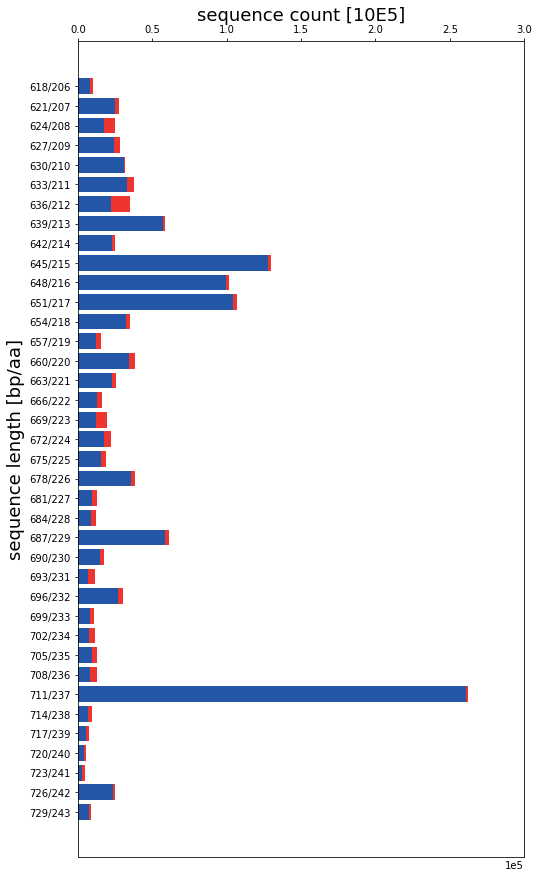

In [112]:
### Plot for Figure 4 B

### dictionary of empirically determined consensus sequences formated for use of regular expressions

                 #{"length" : ["consensus", counter_match, counter_missmatch]}
consensus_dic = {"15" : ["SNGLKVDGGGHLHCN",0,0],
                 "16" : ["SNGALKVDGGGHLHCN",0,0],
                 "17" : ["SNGPVMKVDGGGHLHCN",0,0],
                 "18" : ["SNGPVMQKVDGGGHLHCN",0,0],
                 "19" : ["SNGPVMQKKVDGGGHLHCN",0,0],
                 "20" : ["SNGPVMQKLKVDGGGHLHCN",0,0],
                 "21" : ["SNGPVMQKKTKVDGGGHLHCN",0,0],
                 "22" : ["SNGPVMQKKTLKVDGGGHLHCN",0,0],
                 "23" : ["SNGPVMQKKTALKVDGGGHLHCN",0,0],
                 "24" : ["SNGPVMQKKTKALKVDGGGHLHCN",0,0],
                 "25" : ["SNGPVMQKKTKGALKVDGGGHLHCN",0,0],
                 "26" : ["SNGPVMQKKTKGWALKVDGGGHLHCN",0,0],
                 "27" : ["SNGPVMQKKTKGWGALKVDGGGHLHCN",0,0],
                 "28" : ["SNGPVMQKKTKGWEGALKVDGGGHLHCN",0,0],
                 "29" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]ALKVDGGGHLHCN",0,0],
                 "30" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]TALKVDGGGHLHCN",0,0],
                 "31" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]ALKVDGGGHLHCN",0,0],
                 "32" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MALKVDGGGHLHCN",0,0],
                 "33" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMALKVDGGGHLHCN",0,0],
                 "34" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYALKVDGGGHLHCN",0,0],
                 "35" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPALKVDGGGHLHCN",0,0],
                 "36" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPAALKVDGGGHLHCN",0,0],
                 "37" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADALKVDGGGHLHCN",0,0],
                 "38" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGALKVDGGGHLHCN",0,0],
                 "39" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGALKVDGGGHLHCN",0,0],
                 "40" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGGALKVDGGGHLHCN",0,0],
                 "41" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRALKVDGGGHLHCN",0,0],
                 "42" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGALKVDGGGHLHCN",0,0],
                 "43" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGYALKVDGGGHLHCN",0,0],
                 "44" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGY[A-Z*]ALKVDGGGHLHCN",0,0],
                 "45" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGY[A-Z*]DALKVDGGGHLHCN",0,0],
                 "46" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGY[A-Z*]D[A-Z*]ALKVDGGGHLHCN",0,0],
                 "47" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGY[A-Z*]D[A-Z*]GALKVDGGGHLHCN",0,0],
                 "48" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGY[A-Z*]D[A-Z*]ALALKVDGGGHLHCN",0,0],
                 "49" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGY[A-Z*]D[A-Z*]ALGALKVDGGGHLHCN",0,0],
                 "50" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGY[A-Z*]D[A-Z*]ALKGALKVDGGGHLHCN",0,0],
                 "51" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGY[A-Z*]D[A-Z*]ALKVGALKVDGGGHLHCN",0,0],
                 "52" : ["SNGPVMQKKTKGWE[A-Z*][A-Z*]T[A-Z*]MMYPADGGLRGY[A-Z*]D[A-Z*]ALKVDGALKVDGGGHLHCN",0,0]
                }

### loops through dictionary of all valid DNA sequences
for DNA in DNA_dic_all.keys():
    ### check for in frame variants
    if len(DNA) % 3 == 0:
        ### translate to protein
        protein = str(Seq(DNA, IUPAC.unambiguous_dna).translate())
        pro_len = str(len(protein))
        
        ### match with consensus sequence and count match/missmatch, allow up to 3 missmatches
        if pro_len in consensus_dic:
            template = regex.compile("("+ consensus_dic[pro_len][0] + "){s<=3}")
            
            if template.match(protein):
                consensus_dic[pro_len][1]+=DNA_dic_all[DNA]
            else:
                consensus_dic[pro_len][2]+=DNA_dic_all[DNA]

                
### figure parameters                 
plt.figure(figsize=(8,15))
plt.gca().invert_yaxis()
plt.gca().xaxis.set_ticks_position('top');
plt.gca().xaxis.set_label_position('top') 
plt.ticklabel_format(axis='x', style='sci',scilimits=(0,0))
plt.xlim(0,300000)

### bar plot
p1 = plt.barh(range(len(consensus_dic)), [x[1] for x in list(consensus_dic.values())], align='center', color="#2356A7");
p2 = plt.barh(range(len(consensus_dic)), [x[2] for x in list(consensus_dic.values())], left = [x[1] for x in list(consensus_dic.values())] , align='center', color="#EE342E");


### labels
plt.yticks(range(len(consensus_dic)), [str((int(x)+191)*3)+"/"+str((int(x)+191)) for x in list(consensus_dic.keys())]);              
plt.xlabel('sequence count [10E5]', fontsize=18)
plt.ylabel("sequence length [bp/aa]", fontsize=18)

### save vectorized figure
plt.savefig("Figure_4B.svg")

### Figure 5

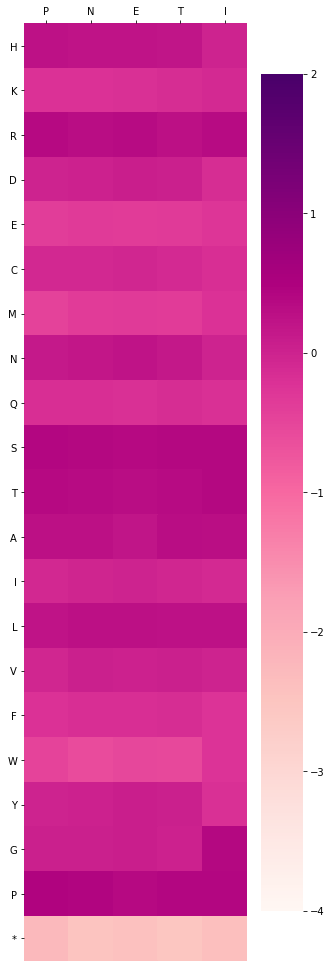

In [109]:
### Plot for figure 5 B 
### figure 5B is a composit of multiple datasets, which have to be analized seperately. 


### figure parameters
plt.figure(figsize=(5,20))
ax = plt.axes()
ax.xaxis.set_ticks_position('top');



### labels
xticklabels = ["P","N","E","T","I"]

sns.heatmap(np.log10((unique_counting_table/float(sum(peptide_lib.values()))).transpose()*100),
            vmin=-4, vmax=2, cmap="RdPu", xticklabels=xticklabels, 
            yticklabels=amino_acids,cbar_kws={"orientation": "vertical"}, square =True );

plt.yticks(rotation=0);

### save vectorized figure
plt.savefig("Figure_5B.svg")